[Repo Link](https://github.com/habibaelghazouly/ML-projects.git)

## Imports

In [2]:
import sys
sys.path.append("..")
from src import preprocess_mnist
from src import NNModel
from src import train_model
from src import plot_training_curves
from src import detect_convergence, plot_convergence 
from src.NNs.helpers import get_gradients
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import pandas as pd
import time

## Displaying Non-Flattened MNIST Images

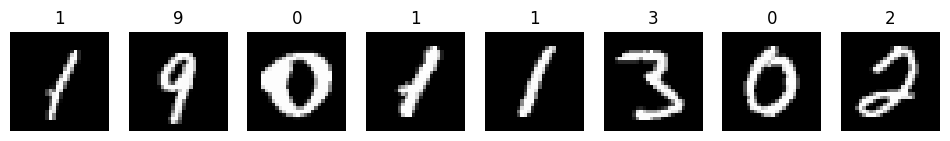

In [3]:
train_loader, val_loader, test_loader = preprocess_mnist(flatten=False)

images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(str(labels[i].item()))
    axes[i].axis('off')
plt.show()


## Displaying Flattened MNIST Data Information

In [4]:
train_loader, val_loader, test_loader = preprocess_mnist(batch_size=64, augment=False, flatten=True)

images, labels = next(iter(train_loader))
print(f"Images batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")
print(f"Example labels: {labels[:10]}")

Images batch shape: torch.Size([64, 784])
Labels batch shape: torch.Size([64])
Example labels: tensor([1, 5, 6, 8, 8, 1, 2, 3, 6, 0])


Epoch 1/10 | Train Loss: 1.1604 | Train Acc: 70.93% | Val Loss: 0.5191 | Val Acc: 85.94%
New best model found (val_loss=0.5191)
Checkpoint saved at: ./checkpoints/mnist.pth
Epoch 2/10 | Train Loss: 0.4076 | Train Acc: 88.62% | Val Loss: 0.3772 | Val Acc: 89.35%
New best model found (val_loss=0.3772)
Checkpoint saved at: ./checkpoints/mnist.pth
Epoch 3/10 | Train Loss: 0.3183 | Train Acc: 90.89% | Val Loss: 0.3152 | Val Acc: 91.00%
New best model found (val_loss=0.3152)
Checkpoint saved at: ./checkpoints/mnist.pth
Epoch 4/10 | Train Loss: 0.2765 | Train Acc: 92.05% | Val Loss: 0.2880 | Val Acc: 91.62%
New best model found (val_loss=0.2880)
Checkpoint saved at: ./checkpoints/mnist.pth
Epoch 5/10 | Train Loss: 0.2485 | Train Acc: 92.89% | Val Loss: 0.2580 | Val Acc: 92.70%
New best model found (val_loss=0.2580)
Checkpoint saved at: ./checkpoints/mnist.pth
Epoch 6/10 | Train Loss: 0.2264 | Train Acc: 93.45% | Val Loss: 0.2430 | Val Acc: 93.26%
New best model found (val_loss=0.2430)
Checkpo

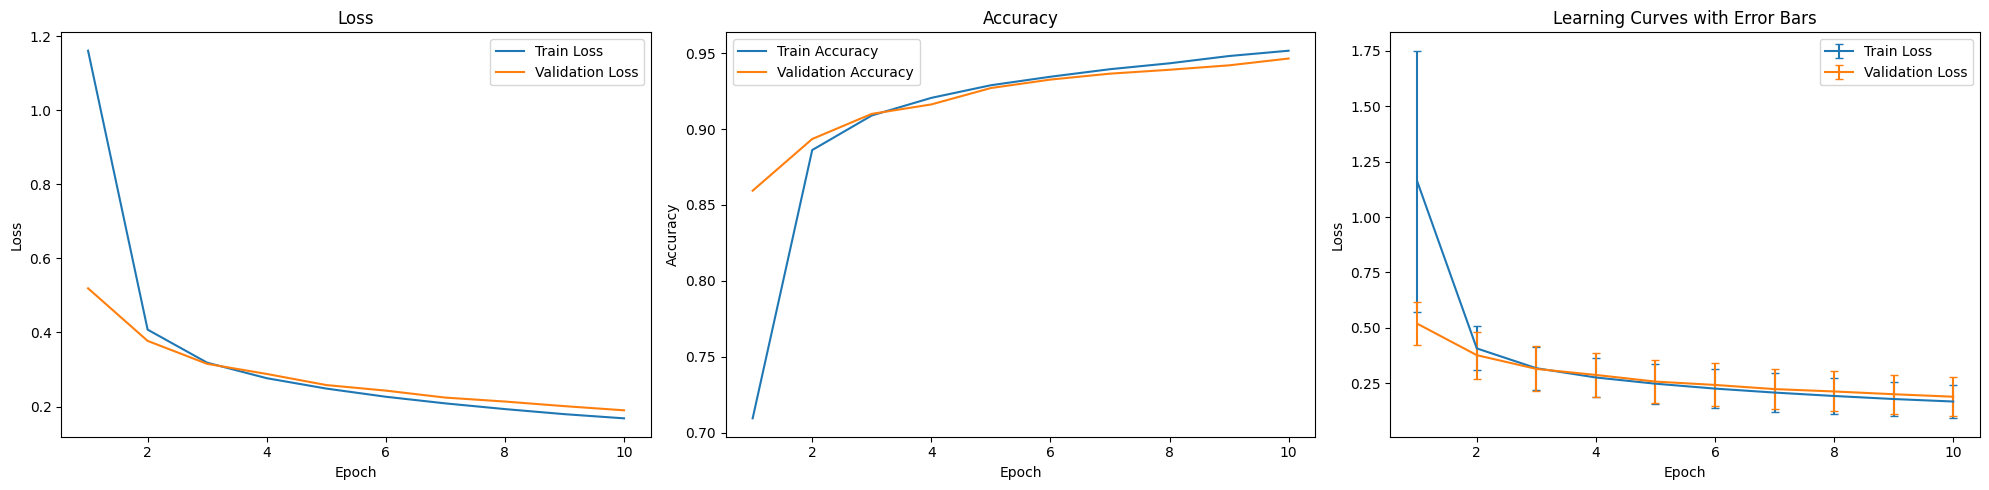

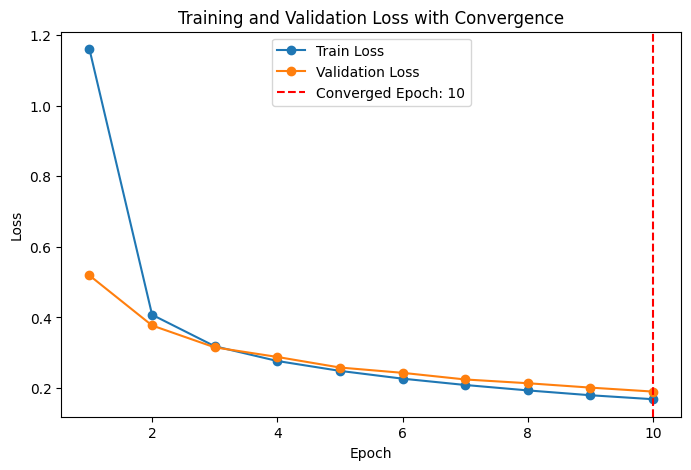

In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, loss, optimizer
model = NNModel().to(device)
model.apply(model._init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 10

checkpoint_path = "./checkpoints/mnist.pth"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
# Train
history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=epochs, device=device, checkpoint_path=checkpoint_path)

# Plot
plot_training_curves(history)
conv_epoch = detect_convergence(history["val_loss_mean"])
plot_convergence(history["train_loss_mean"], history["val_loss_mean"], conv_epoch)


# Analysis


### 1. Learning Rate Analysis

In [ ]:
# Test values : [0.001, 0.01, 0.1, 1.0]
learning_rates = [0.001, 0.01, 0.1, 1.0]

results_lr = {}
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = NNModel().to(device)
    model.apply(model._init_weights)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    result = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=epochs, device=device)
    results_lr[lr] = result
    plot_training_curves(result)
    conv_epoch = detect_convergence(result["val_loss_mean"])
    plot_convergence(result["train_loss_mean"], result["val_loss_mean"], conv_epoch)

# best lr 
best_lr = None
best_acc = 0.0

for lr, history in results_lr.items():
    val_acc = history["val_acc_mean"][-1]
    print(f"LR {lr:<5} → Final Val Acc: {val_acc*100:.2f}%")
    if val_acc > best_acc:
        best_acc = val_acc
        best_lr = lr

print(f"\nBest Learning Rate: {best_lr} with Val Acc = {best_acc*100:.2f}%")


### 2. Batch Size Analysis


In [ ]:
# get the full-batch sample and calculating gradient

full_batch_images, full_batch_labels = next(iter(train_loader))
full_batch_images, full_batch_labels = full_batch_images.to(device), full_batch_labels.to(device)

model = NNModel().to(device)
model.apply(model._init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)    
full_result = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, device=device)

full_batch_gradients = get_gradients(model, criterion, full_batch_images, full_batch_labels)

# Test Values : [16, 32, 64, 128]
batch_sizes = [16, 32, 64, 128]
epochs = 10
results_bs = {} 
grad_noise_results = []

for bs in batch_sizes:  
    print(f"Training with batch size: {bs}")
    train_loader_bs, val_loader_bs, test_loader_bs = preprocess_mnist(batch_size=bs, augment=False, flatten=True)
   
    # model, loss, optimizer
    model = NNModel().to(device)
    model.apply(model._init_weights)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    
    start_time = time.time()
    result = train_model(model, train_loader_bs, val_loader_bs, criterion, optimizer, epochs=epochs, device=device)
    train_time = time.time() - start_time
    results_bs[bs] = result

    final_val_acc = result["val_acc_mean"][-1]
 
    print(f"----- Final Val Acc: {final_val_acc*100:.2f}% | Train Time: {train_time:.2f}s -----")


    # Random stochastic batch
    batch_inputs, batch_targets = next(iter(DataLoader(train_loader_bs.dataset, batch_size=bs, shuffle=True)))
    batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
    
    stoch_grads = get_gradients(model, criterion, batch_inputs.view(batch_inputs.size(0), -1), batch_targets)
    
    # Gradient noise 
    grad_noise = [sg - tg for sg, tg in zip(stoch_grads, full_batch_gradients)]
    noise_norm = torch.sqrt(sum([g.pow(2).sum() for g in grad_noise])).item()
    
    grad_noise_results.append((bs, final_val_acc * 100, train_time, noise_norm))
    print(f"----- Gradient Noise : {noise_norm:.6f} -----")


summary_df = pd.DataFrame(grad_noise_results, columns=["Batch Size", "Val Accuracy (%)", "Train Time (s)", "Gradient Noise"])
display(summary_df)

 
# best batch size
best_bs = None
best_acc = 0.0  
for bs, history in results_bs.items():
    val_acc = history["val_acc_mean"][-1]
    print(f"BS {bs:<5} → Final Val Acc: {val_acc*100:.2f}%")
    if val_acc > best_acc:
        best_acc = val_acc
        best_bs = bs


#  visualization
plt.figure(figsize=(6,4))
plt.plot(summary_df["Batch Size"], summary_df["Gradient Noise"], marker='o')
plt.title("Gradient Noise vs Batch Size (MNIST)")
plt.xlabel("Batch Size")
plt.ylabel("Gradient Noise")
plt.grid(True)
plt.show()

print(f"\nBest Batch Size: {best_bs} with Val Acc = {best_acc*100:.2f}%")


### 3. Architecture Analysis

In [ ]:
layers = [2, 3, 4, 5]
neurons_per_layer = [64, 128, 256, 512]
epochs = 2
results_arch = {}

for num_layers in layers:
    for neurons in neurons_per_layer:
        print(f"Training with {num_layers} layers and {neurons} neurons per layer")

        model = NNModel(hidden_sizes=[neurons]*num_layers).to(device)
        model.apply(model._init_weights)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        
        result = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=epochs, device=device)
      
        results_arch[(num_layers, neurons)] = result

arch_df = pd.DataFrame(
    [(num_layers, neurons, res["val_acc_mean"][-1] * 100,) 
     for (num_layers, neurons), res in results_arch.items()],
    columns=["Num Layers", "Neurons per Layer", "Val Accuracy (%)"]
)
display(arch_df)            

best_row = arch_df.loc[arch_df["Val Accuracy (%)"].idxmax()]
print(f"\nBest Architecture: {int(best_row['Num Layers'])} layers × {int(best_row['Neurons per Layer'])} neurons")
print(f"Validation Accuracy: {best_row['Val Accuracy (%)']:.2f}%")